# DigiLab 4 - Unit Commitment 
Author: Emil G. Melfald, University of South-Eastern Norway <br><br>
This notebook will teach you to use PyPSA for Unit Commitment (UC) calculations. We will investigate how we may inform the UC with different cost data, and how we constrain the UC with rise/fall times, and minimum up- and down times. 

## Prerequisites 
You must have completed **Assignment 1** in the EPE2316 course. That also includes Digilab 1 to 3. Familiarity with UC from the lectures is adviced. 

## Learning Objectives 
By the end of this notebook you should be able to: 
- Formulate UC in PyPSA 
- Add cost data to generating units 
- Add UC constraints 
- Add and differentiate between dispatchable and non-dispatchable units
- Visualize UC result data 

## Contents 
1. [First look at UC in PyPSA](#PyPSA)
2. [Adding startup costs]()
3. [Adding minimum uptime]() 
4. [Adding min and max ramp rate]() 
5. [Adding non-controllable generating units]() 

# [First look at UC in PyPSA]()
Assume the following grid, which is equivalent to the grid you constructed in **Assignment 1**. Assume in this first section that both machines are controllable hydro power units, both with a capacity of 6 MW. The marginal cost (cost per MW) for G1 (bus 1) and G2 (bus 3) are 100 and 50 NOK/MW, respectively.  

![Image of the power system under study](Power_System_Drawing.png)

In [42]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import pypsa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<Axes: xlabel='Hour'>

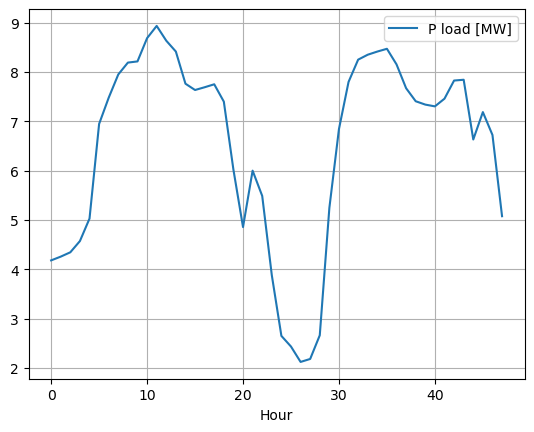

In [94]:
# To evaluate the UC we need a load profile 
load_data = pd.read_csv("load_data.csv") # Some load data
load_data.plot("Hour", "P load [MW]", grid=True)

In [95]:
P_load = load_data["P load [MW]"].values
V_base = 22 

network = pypsa.Network(snapshots=range(len(P_load))) # Tells PyPSA how many datapoints should be considered

network.add("Bus", "Bus 1", v_nom=V_base)
network.add("Bus", "Bus 2", v_nom=V_base)
network.add("Bus", "Bus 3", v_nom=V_base)
network.add("Line", "Line 12", bus0="Bus 1", bus1="Bus 2", r=3.0 , x=8.0, s_nom=20)
network.add("Line", "Line 23", bus0="Bus 2", bus1="Bus 3", r=1.0 , x=4.0, s_nom=20)
network.add("Line", "Line 13", bus0="Bus 1", bus1="Bus 3", r=10.0, x=35.0, s_nom=20)

network.add("Generator", "Hydro 1", bus="Bus 1", committable=True, p_min_pu=0.3, p_nom=5, marginal_cost=100)
network.add("Generator", "Hydro 2", bus="Bus 3", committable=True, p_min_pu=0.3, p_nom=5, marginal_cost=50)

network.add("Load", "Load 1", bus="Bus 2", p_set=P_load)

In [96]:
network.optimize()

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 528 primals, 0 duals
Objective: 2.04e+04
Solver model: not available
Solver message: integer optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\emelf\AppData\Local\Temp\linopy-problem-534m9ay2.lp --output
 C:\Users\emelf\AppData\Local\Temp\linopy-solve-f9h83_1d.sol
Reading problem data from 'C:\Users\emelf\AppData\Local\Temp\linopy-problem-534m9ay2.lp'...
864 rows, 528 columns, 1772 non-zeros
288 integer variables, all of which are binary
4997 lines were read
GLPK Integer Optimizer 5.0
864 rows, 528 columns, 1772 non-zeros
288 integer variables, all of which are binary
Preprocessing...
14 hidden packing inequaliti(es) were detected
534 rows, 486 columns, 1355 non-zeros
253 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  7.231e+03  ratio =  7.231e+03
GM: min|aij| =  5.814e-01  max|aij| =  1.720e+00  ratio =  2.958e+00
EQ: min|aij| =  3.381e-01  max|aij| =  1.000e+00  ratio =  2.958e+00
2N: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Constructing initial basis...
Size of tria

('ok', 'optimal')

### Plotting the generator dispatch results 

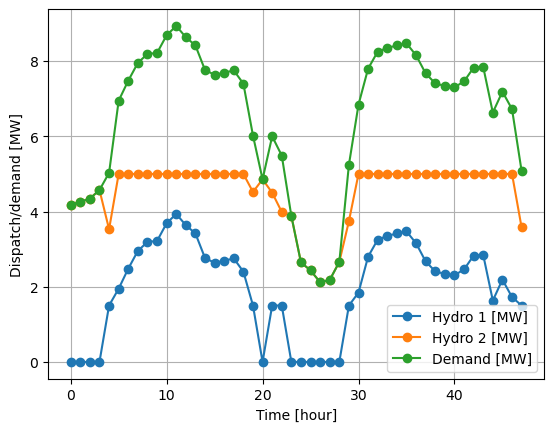

In [97]:
G1_P = network.generators_t.p["Hydro 1"].values
G2_P = network.generators_t.p["Hydro 2"].values

plt.plot(G1_P, 'o-', label="Hydro 1 [MW]")
plt.plot(G2_P, 'o-', label="Hydro 2 [MW]")
plt.plot(P_load, 'o-', label="Demand [MW]")
plt.legend() 
plt.grid() 

plt.xlabel("Time [hour]")
plt.ylabel("Dispatch/demand [MW]")

plt.show() 


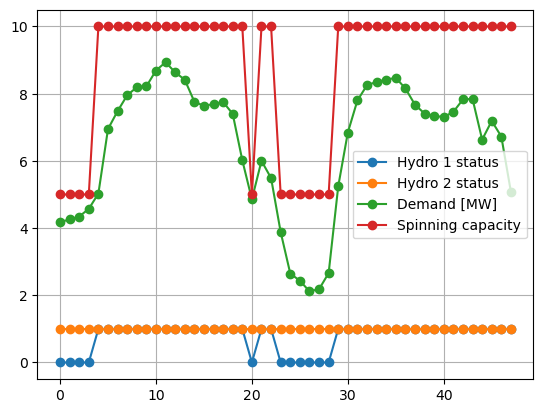

In [98]:
G1_status = network.generators_t.status["Hydro 1"].values
G2_status = network.generators_t.status["Hydro 2"].values

plt.plot(G1_status, 'o-', label="Hydro 1 status")
plt.plot(G2_status, 'o-', label="Hydro 2 status")
plt.plot(load_data["P load [MW]"].values, 'o-', label="Demand [MW]")
plt.plot(G1_status*5.0 + G2_status*5.0, 'o-', label="Spinning capacity")
plt.legend() 
plt.grid() 

plt.show() 

# [Adding startup costs]() 
The keyword argument "start_up_cost" can be added when adding the generator units. If we set the startup costs of both units to 1000 NOK then the UC results will change to both units being on at all times. 

In [110]:
network = pypsa.Network(snapshots=range(len(P_load)))

network.add("Bus", "Bus 1", v_nom=V_base)
network.add("Bus", "Bus 2", v_nom=V_base)
network.add("Bus", "Bus 3", v_nom=V_base)
network.add("Line", "Line 12", bus0="Bus 1", bus1="Bus 2", r=3.0 , x=8.0, s_nom=20)
network.add("Line", "Line 23", bus0="Bus 2", bus1="Bus 3", r=1.0 , x=4.0, s_nom=20)
network.add("Line", "Line 13", bus0="Bus 1", bus1="Bus 3", r=10.0, x=35.0, s_nom=20)

network.add("Generator", "Hydro 1", bus="Bus 1", committable=True, 
            p_min_pu=0.3, p_nom=5, marginal_cost=100, start_up_cost=1000)
network.add("Generator", "Hydro 2", bus="Bus 3", committable=True, 
            p_min_pu=0.3, p_nom=5, marginal_cost=50,  start_up_cost=1000)

network.add("Load", "Load 1", bus="Bus 2", p_set=P_load)
info = network.optimize()

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 528 primals, 0 duals
Objective: 2.18e+04
Solver model: not available
Solver message: integer optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\emelf\AppData\Local\Temp\linopy-problem-nypopf0m.lp --output
 C:\Users\emelf\AppData\Local\Temp\linopy-solve-_83l5zba.sol
Reading problem data from 'C:\Users\emelf\AppData\Local\Temp\linopy-problem-nypopf0m.lp'...
864 rows, 528 columns, 1772 non-zeros
288 integer variables, all of which are binary
5093 lines were read
GLPK Integer Optimizer 5.0
864 rows, 528 columns, 1772 non-zeros
288 integer variables, all of which are binary
Preprocessing...
14 hidden packing inequaliti(es) were detected
534 rows, 486 columns, 1355 non-zeros
253 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  7.231e+03  ratio =  7.231e+03
GM: min|aij| =  5.814e-01  max|aij| =  1.720e+00  ratio =  2.958e+00
EQ: min|aij| =  3.381e-01  max|aij| =  1.000e+00  ratio =  2.958e+00
2N: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Constructing initial basis...
Size of tria

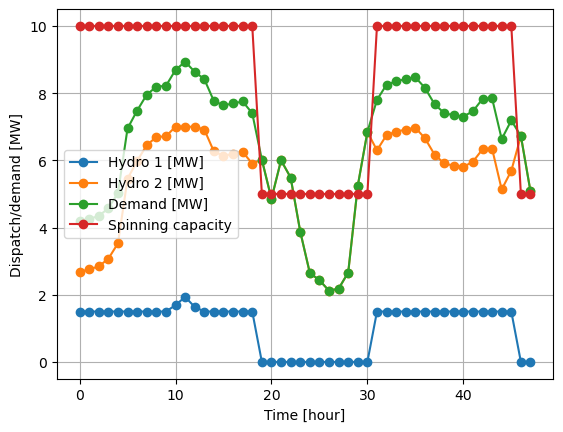

In [113]:
G1_P = network.generators_t.p["Hydro 1"].values
G2_P = network.generators_t.p["Hydro 2"].values
G1_status = network.generators_t.status["Hydro 1"].values
G2_status = network.generators_t.status["Hydro 2"].values

plt.plot(G1_P, 'o-', label="Hydro 1 [MW]")
plt.plot(G2_P, 'o-', label="Hydro 2 [MW]")
plt.plot(P_load, 'o-', label="Demand [MW]")
plt.plot(G1_status*5.0 + G2_status*5.0, 'o-', label="Spinning capacity")
plt.legend() 
plt.grid() 

plt.xlabel("Time [hour]")
plt.ylabel("Dispatch/demand [MW]")
plt.show() 

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 528 primals, 0 duals
Objective: 1.92e+04
Solver model: not available
Solver message: integer optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\emelf\AppData\Local\Temp\linopy-problem-wduon0yy.lp --output
 C:\Users\emelf\AppData\Local\Temp\linopy-solve-nh_d80xe.sol
Reading problem data from 'C:\Users\emelf\AppData\Local\Temp\linopy-problem-wduon0yy.lp'...
864 rows, 528 columns, 1772 non-zeros
288 integer variables, all of which are binary
5093 lines were read
GLPK Integer Optimizer 5.0
864 rows, 528 columns, 1772 non-zeros
288 integer variables, all of which are binary
Preprocessing...
2 hidden packing inequaliti(es) were detected
2 constraint coefficient(s) were reduced
574 rows, 526 columns, 1480 non-zeros
286 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  7.231e+03  ratio =  7.231e+03
GM: min|aij| =  5.814e-01  max|aij| =  1.720e+00  ratio =  2.958e+00
EQ: min|aij| =  3.381e-01  max|aij| =  1.000e+00  ratio =  2.958e+00
2N: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Co

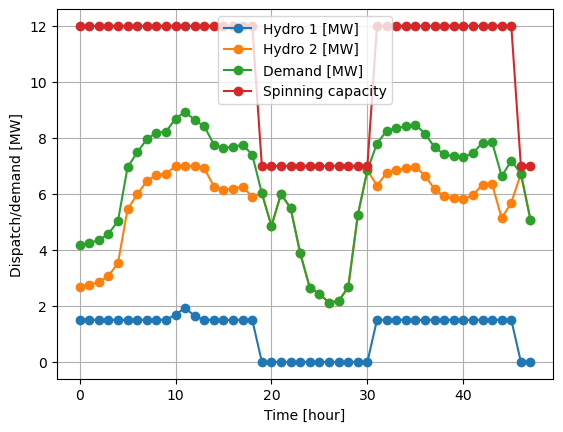

In [114]:
network = pypsa.Network(snapshots=range(len(P_load))) 

network.add("Bus", "Bus 1", v_nom=V_base)
network.add("Bus", "Bus 2", v_nom=V_base)
network.add("Bus", "Bus 3", v_nom=V_base)
network.add("Line", "Line 12", bus0="Bus 1", bus1="Bus 2", r=3.0 , x=8.0, s_nom=20)
network.add("Line", "Line 23", bus0="Bus 2", bus1="Bus 3", r=1.0 , x=4.0, s_nom=20)
network.add("Line", "Line 13", bus0="Bus 1", bus1="Bus 3", r=10.0, x=35.0, s_nom=20)

network.add("Generator", "Hydro 1", bus="Bus 1", committable=True, p_min_pu=0.3, p_nom=5, marginal_cost=100, start_up_cost=1000)
network.add("Generator", "Hydro 2", bus="Bus 3", committable=True, p_min_pu=0.3, p_nom=7, marginal_cost=50,  start_up_cost=1000)

network.add("Load", "Load 1", bus="Bus 2", p_set=P_load)
info = network.optimize()

G1_P = network.generators_t.p["Hydro 1"].values
G2_P = network.generators_t.p["Hydro 2"].values
G1_status = network.generators_t.status["Hydro 1"].values
G2_status = network.generators_t.status["Hydro 2"].values

plt.plot(G1_P, 'o-', label="Hydro 1 [MW]")
plt.plot(G2_P, 'o-', label="Hydro 2 [MW]")
plt.plot(P_load, 'o-', label="Demand [MW]")
plt.plot(G1_status*5.0 + G2_status*7.0, 'o-', label="Spinning capacity")
plt.legend() 
plt.grid() 

plt.xlabel("Time [hour]")
plt.ylabel("Dispatch/demand [MW]")
plt.show() 